In [1]:
import os
import json
import torch
import numpy as np
import PIL
from PIL import Image
from IPython.display import HTML
from pyramid_dit import PyramidDiTForVideoGeneration
from IPython.display import Image as ipython_image
from diffusers.utils import load_image, export_to_video, export_to_gif

/home/sxk230060/miniconda3/envs/pyramid/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
variant='diffusion_transformer_384p'       # For low resolution variant
# variant='diffusion_transformer_768p'     # For high resolution variant

model_name = "pyramid_mmdit"   # select the model "pyramid_flux" or "pyramid_mmdit"
model_dtype = 'bf16'

if model_name == "pyramid_flux":
    model_path = "/mnt/sda1/saksham/TI2AV/pyramid_flux/"  # The downloaded checkpoint dir
    new_wts='/mnt/sda1/saksham/TI2AV/ckpts-pyramid-flux-ar/checkpoint-40000/pytorch_model_fsdp.bin'
elif model_name == "pyramid_mmdit":
    model_path = "/mnt/sda1/saksham/TI2AV/pyramid/"  # The downloaded checkpoint dir
    new_wts='/mnt/sda1/saksham/TI2AV/ckpts-pyramid-temp-ar/checkpoint-40000/pytorch_model_fsdp.bin'

device_id = 2
torch.cuda.set_device(device_id)

model = PyramidDiTForVideoGeneration(
    model_path,
    model_dtype,
    model_name=model_name,
    model_variant=variant,
)

model.dit.load_state_dict(torch.load(new_wts, map_location="cpu"))

model.vae.to("cuda")
model.dit.to("cuda")
model.text_encoder.to("cuda")

model.vae.enable_tiling()

if model_dtype == "bf16":
    torch_dtype = torch.bfloat16 
elif model_dtype == "fp16":
    torch_dtype = torch.float16
else:
    torch_dtype = torch.float32

def resize_crop_image(img: PIL.Image.Image, tgt_width, tgt_height):
    ori_width, ori_height = img.width, img.height
    scale = max(tgt_width / ori_width, tgt_height / ori_height)
    resized_width = round(ori_width * scale)
    resized_height = round(ori_height * scale)
    img = img.resize((resized_width, resized_height), resample=PIL.Image.LANCZOS)

    left = (resized_width - tgt_width) / 2
    top = (resized_height - tgt_height) / 2
    right = (resized_width + tgt_width) / 2
    bottom = (resized_height + tgt_height) / 2

    # Crop the center of the image
    img = img.crop((left, top, right, bottom))
    return img

def show_video(ori_path, rec_path, width="100%"):
    html = ''
    if ori_path is not None:
        html += f"""<video controls="" name="media" data-fullscreen-container="true" width="{width}">
        <source src="{ori_path}" type="video/mp4">
        </video>
        """
    
    html += f"""<video controls="" name="media" data-fullscreen-container="true" width="{width}">
    <source src="{rec_path}" type="video/mp4">
    </video>
    """
    return HTML(html)

Using temporal causal attention
We interp the position embedding of condition latents


You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers
Loading checkpoint shards: 100%|██████████| 2/2 [00:02<00:00,  1.33s/it]


The start sigmas and end sigmas of each stage is Start: {0: 1.0, 1: 0.8002399489209289, 2: 0.5007496155411024}, End: {0: 0.6669999957084656, 1: 0.33399999141693115, 2: 0.0}, Ori_start: {0: 1.0, 1: 0.6669999957084656, 2: 0.33399999141693115}


In [ ]:
prompt = "A man with light brown hair, dressed in a dark turtleneck and black pants, is seen playing a cello with intense concentration. He is seated, with his right hand skillfully navigating the strings and his left hand supporting the bow. An orchestra, including musicians with violins and a double bass, is visible in the background, indicating a live performance. The warm stage lighting enhances the mood of the event. Over time, the man's attire is described as a grey turtleneck and black pants, and the setting is revealed to be an outdoor concert with a microphone stand and a bare tree structure."
# prompt ='playing violin fiddle'
# used for 384p model variant
width = 640
height = 384

# width = 256
# height = 256

# used for 768p model variant
# width = 1280
# height = 768

temp = 16  # temp in [1, 31] <=> frame in [1, 241] <=> duration in [0, 10s]
FPS = 24
# Noting that, for the 384p version, only supports maximum 5s generation (temp = 16)

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate(
        prompt=prompt,
        num_inference_steps=[20, 20, 20],
        video_num_inference_steps=[10, 10, 10],
        height=height,
        width=width,
        temp=temp,
        guidance_scale=7.0,         # The guidance for the first frame, set it to 7 for 384p variant
        video_guidance_scale=5.0,   # The guidance for the other video latent
        output_type="pil",
        save_memory=True,           # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

export_to_video(frames, "./text_to_video_sample.mp4", fps=FPS)
show_video(None, "./text_to_video_sample.mp4", "70%")

#### Image-to-Video

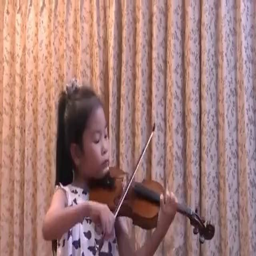

100%|██████████| 3/3 [00:11<00:00,  3.81s/it]
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [5]:
image_path = 'assets/violin_orig.jpg'
image = Image.open(image_path).convert("RGB")

# used for 384p model variant
# width = 640
# height = 384
# temp = 16
# FPS = 24

CFG = 7.0
V_CFG = 4.0

width = 256
height = 256
temp = 4
FPS = 8

image = image.resize((width, height))
image = resize_crop_image(image, width, height)

display(image)

prompt = "A small girl is playing a violin with a bow."
# prompt = "A dog is barking."
# prompt = "A gunshot is being fired."

with torch.no_grad(), torch.cuda.amp.autocast(enabled=True if model_dtype != 'fp32' else False, dtype=torch_dtype):
    frames = model.generate_i2v(
        prompt=prompt,
        input_image=image,
        num_inference_steps=[10, 10, 10],
        temp=temp,
        guidance_scale=CFG,
        video_guidance_scale=V_CFG,
        output_type="pil",
        save_memory=True,         # If you have enough GPU memory, set it to `False` to improve vae decoding speed
    )

file_name = "violin_sd3_40k.mp4"

export_to_video(frames, f"temp_samples/{file_name}", fps=FPS)
show_video(None, f"temp_samples/{file_name}", "50%")